In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heartpy as hp #이 모듈은 깔아야 import 할수 있음
os.chdir('/Users/hoseong/Desktop/2021/기타/졸논/종합/NNinterval_strd') #경로 설정

In [12]:
colname = ['ppg_grn', 'temp', 'GSR', 'filter1', 'filter2'] #column name 설정
data = pd.read_csv('WStds2e2.csv', header = None) #column name이 없이 데이터만 있어서 header=None 설정
data.columns = colname #data의 column과 colname을 일치시킨다

In [13]:
fs = 398 #주파수 설정 (398헤르츠)

working_data, measures = hp.process(data['ppg_grn'].values, fs, calc_freq=True)
#calc_freq: _optional_ whether to calculate frequency domain measures. 
#Default = false Note: can cause slowdowns in some cases.
#note we need calc_freq if we want frequency-domain measures
#output으로 나오는 data가 2개가 있음

print(measures['bpm']) #returns BPM value 
print(measures['lf/hf']) # returns lf/hf 심전도

97.60860646396499
0.6264931969735912


/Users/hoseong/opt/anaconda3/lib/python3.8/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)


/Users/hoseong/opt/anaconda3/lib/python3.8/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


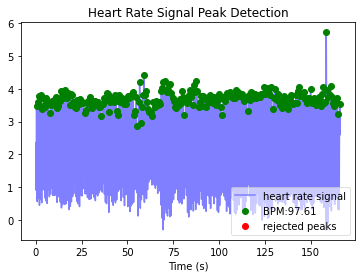

In [4]:
hp.plotter(working_data, measures) #hp data plot하기 (NN간격 뽑기)

In [5]:
#결과값 딕셔너리로 반환 함수
def NN_dictionary(working_data, time_interval, strd): #기존 코드에서  stride input 추가
    jump = int(time_interval/strd)
    RR_list = working_data['RR_list'] #working data의 RR_list를 저장
    cum = np.cumsum(RR_list) #RR interval 데이터의 누적 벡터
    time = list(range(0, int(cum[-1]), strd)) # cum 시작과 끝을 뽑아내고 (=주어진 time 범위)
                                                       # time interval 간격 만큼으로 range를 자르고 list 변환
                                                       # 말은 즉슨 일정한 시간 간격으로 range를 잘랐다는 것 
    
    # 만약 [20 30 50 30 20]의 RR interval이 있다면
    # 누적 벡터로 [20 50 100 130 150]을 만들어준다음
    # time interval대로 자른다
    

    meanNN = [] #empty vector
    medianNN = [] 
    SDNN = []
    pNN50 = []
    NN50 = []
    RMSSD = []
    
    for i in range(0, len(time) - jump): #길이 0~time list의 길이-jump 까지 (loop 돌아가는 횟수 = time list와 동일)
        idx = (cum >= time[i])&(cum < time[i + jump]) #TF로 원하는 구간의 index 반환
        NN = RR_list[idx] #true(1)에 해당하는 부분만 잘려서 나옴
        diff = [] #빈 list
        for j in range(0, len(NN) -1): #NN의 길이 횟수-1만큼 loop 돌아감
            diff.append(abs(NN[j+1]-NN[j])) #연속적 NN간격 차이 쌓기 (abs = 절댓값)
            #연속적 NN간격 차이가 50ms를 초과하는 개수를 NN50 count라고 한다

        num50 = sum(np.array(diff) > 50)    # [0 0 0 1 1 0] 이면 num50 = 2가 된다
                                            # 대소 비교를 위해 array로 변환 후 50보다 큰 것의 개수 num50 저장

        if len(diff) > 0:
            p50 =  num50/len(diff)
        else:
            p50 = 0  #diff가 빈 리스트면 p50은 0이고 값이 있다면 len(diff)로 나누어 백분율로 계산
        rmssd = np.sqrt(np.mean(sum(NN**2))) #표준편차
        #hr = 머 어쩌구 계산

        meanNN.append(np.mean(NN)) #평균
        medianNN.append(np.median(NN)) #중간값
        SDNN.append(np.std(NN)) # 표준편차
        NN50.append(num50) #NN50
        pNN50.append(p50) #p50
        RMSSD.append(rmssd) #rmssd
        #HR.append(hr)

    result = {'meanNN': meanNN,  #딕셔너리로 만들엇다
              'medianNN':medianNN, 
              'SDNN': SDNN,
             'pNN50':pNN50,
             'NN50':NN50,
             'RMSSD':RMSSD #,'HR':HR 
             }

    return result

In [2]:
Dir = '/Users/hoseong/Desktop/2021/기타/졸논/종합/NNinterval_strd' #경로 설정
os.chdir(Dir)
filelist = os.listdir(Dir) #Dir 경로 폴더 안 모든 파일 이름 리스트

NameError: name 'os' is not defined

In [1]:
#폴더 내 모든 파일 csv로 변환
time_interval = 5000
strd = 1250 #stride 설정 / 추가함

for file in filelist:
    data = pd.read_csv(file, header = None)
    data.columns = colname
    fs = 398
    working_data, measures = hp.process(data['ppg_grn'].values, fs, calc_freq=True)
    result = pd.DataFrame(NN_dictionary(working_data, time_interval, strd))
    result.to_csv('NN_strd_'+file, index = False) #to_csv 하면 csv로 반환
    

NameError: name 'filelist' is not defined